In [1]:
import os

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import InterpolationMode, v2
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

In [4]:
def _init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, std=0.02)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0.0)
    elif isinstance(module, nn.RMSNorm):
        nn.init.constant_(module.weight, 1.0)

In [5]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim, image_size):
        super(ImageEncoder, self).__init__()

        model_name = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
        self.backbone = AutoModel.from_pretrained(model_name)

        self.hidden_size = self.backbone.config.hidden_size
        self.grid_size = image_size // 16

        self.pixel_unshuffle = nn.PixelUnshuffle(downscale_factor=2)
        self.proj = nn.Sequential(
            nn.LayerNorm(self.hidden_size * 4),
            nn.Linear(self.hidden_size * 4, embed_dim, bias=False),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim, bias=False),
        )
        self.norm = nn.RMSNorm(embed_dim)

        _init_weights(self.pixel_unshuffle)
        _init_weights(self.proj)
        _init_weights(self.norm)

    def forward(self, x):
        features = self.backbone(x).last_hidden_state[:, 5:, :]
        grid_features = features.transpose(1, 2).view(
            x.shape[0], self.hidden_size, self.grid_size, self.grid_size
        )

        unshuffled = self.pixel_unshuffle(grid_features)
        tokens = unshuffled.flatten(2).transpose(1, 2)
        projected = self.norm(self.proj(tokens))
        return projected

In [6]:
class RotaryPositionalEmbeddings(nn.Module):
    def __init__(self, max_seq_len, embed_dim):
        super(RotaryPositionalEmbeddings, self).__init__()

        inv_freq = 1.0 / (10_000 ** (torch.arange(0, embed_dim, 2).float() / embed_dim))
        t = torch.arange(max_seq_len).float()
        freqs = torch.outer(t, inv_freq)

        self.register_buffer("cos", freqs.cos(), persistent=False)
        self.register_buffer("sin", freqs.sin(), persistent=False)

    def forward(self, x, start_pos=0):
        seq_len = x.shape[-2]

        cos = self.cos[start_pos : start_pos + seq_len].view(1, 1, seq_len, -1)
        sin = self.sin[start_pos : start_pos + seq_len].view(1, 1, seq_len, -1)

        x1 = x[..., 0::2]
        x2 = x[..., 1::2]

        x_out1 = x1 * cos - x2 * sin
        x_out2 = x1 * sin + x2 * cos

        return torch.stack((x_out1, x_out2), dim=-1).flatten(-2)

In [7]:
class BaseMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, max_length):
        super(BaseMultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim**-0.5

        self.pre_norm = nn.RMSNorm(embed_dim)
        self.q_norm = nn.RMSNorm(self.head_dim)
        self.k_norm = nn.RMSNorm(self.head_dim)
        self.rope = RotaryPositionalEmbeddings(max_length, self.head_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def _prepare_qkv(self, q, k, v, start_pos):
        q = q.view(q.shape[0], q.shape[1], self.num_heads, self.head_dim)
        k = k.view(k.shape[0], k.shape[1], self.num_heads, self.head_dim)
        v = v.view(v.shape[0], v.shape[1], self.num_heads, self.head_dim)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        q = self.q_norm(q)
        k = self.k_norm(k)

        q = self.rope(q, start_pos)
        k = self.rope(k, start_pos)
        return q, k, v

    def _compute_attention(self, q, k, v, attn_mask=None, padding_mask=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == 0, float("-inf"))

        if padding_mask is not None:
            padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(padding_mask == 0, float("-inf"))

        attention = torch.softmax(scores, dim=-1)
        context = torch.matmul(attention, v)
        return context

In [8]:
class SelfMultiHeadAttention(BaseMultiHeadAttention):
    def __init__(self, embed_dim, num_heads, max_length):
        super(SelfMultiHeadAttention, self).__init__(embed_dim, num_heads, max_length)

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x, attn_mask=None, padding_mask=None, key_value_cache=None):
        x_norm = self.pre_norm(x)

        q = self.q_proj(x_norm)
        k = self.k_proj(x_norm)
        v = self.v_proj(x_norm)

        start_pos = key_value_cache[0].shape[-2] if key_value_cache is not None else 0
        q, k, v = self._prepare_qkv(q, k, v, start_pos=start_pos)

        if key_value_cache is not None:
            past_k, past_v = key_value_cache

            full_k = torch.cat([past_k, k], dim=-2)
            full_v = torch.cat([past_v, v], dim=-2)
        else:
            full_k = k
            full_v = v

        context = self._compute_attention(q, full_k, full_v, attn_mask, padding_mask)

        batch_size, seq_len, _ = x.shape
        out = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        return x + self.proj(out), (full_k, full_v)

In [9]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(FeedForward, self).__init__()

        self.pre_norm = nn.RMSNorm(embed_dim)
        self.feature = nn.Linear(embed_dim, hidden_dim)
        self.gate = nn.Linear(embed_dim, hidden_dim)
        self.proj = nn.Linear(hidden_dim, embed_dim)

    def forward(self, x):
        x_norm = self.pre_norm(x)
        feature = F.silu(self.feature(x_norm))
        gate = self.gate(x_norm)
        return x + self.proj(feature * gate)

In [10]:
class DecoderTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, max_length):
        super(DecoderTransformerBlock, self).__init__()

        self.self_attention = SelfMultiHeadAttention(embed_dim, num_heads, max_length)
        self.feed_forward = FeedForward(embed_dim, embed_dim * 3)
        self.ffn_norm = nn.RMSNorm(embed_dim)

    def forward(self, x, attn_mask=None, padding_mask=None, key_value_cache=None):
        x, kv = self.self_attention(
            x, attn_mask, padding_mask, key_value_cache=key_value_cache
        )
        x = self.feed_forward(x)
        return x, kv

In [11]:
class DecoderTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, max_length, depth):
        super(DecoderTransformer, self).__init__()

        self.decoder_blocks = nn.ModuleList(
            [
                DecoderTransformerBlock(embed_dim, num_heads, max_length)
                for _ in range(depth)
            ]
        )
        self.final_norm = nn.RMSNorm(embed_dim)
        self.output = nn.Linear(embed_dim, vocab_size)

        self.apply(_init_weights)

    def forward(self, x, attn_mask=None, padding_mask=None, past_key_values=None):
        new_key_values = []

        for i, block in enumerate(self.decoder_blocks):
            layer_past = past_key_values[i] if past_key_values is not None else None

            x, kv = block(x, attn_mask, padding_mask, key_value_cache=layer_past)
            new_key_values.append(kv)

        logits = self.output(self.final_norm(x))
        return logits, new_key_values

In [12]:
class ImageCaption(nn.Module):
    def __init__(
        self,
        embed_dim,
        num_heads,
        depth,
        image_size,
        max_text_tokens,
        token_embeddings,
        tokenizer,
    ):
        super(ImageCaption, self).__init__()

        self.num_image_tokens = (((image_size // 16) - 2) // 2 + 1) ** 2 + 2
        self.total_len = self.num_image_tokens + max_text_tokens + 1

        self.token_embeddings = token_embeddings
        self.vision_encoder = ImageEncoder(embed_dim, image_size)
        self.text_transformer = DecoderTransformer(
            tokenizer.vocab_size, embed_dim, num_heads, self.total_len, depth
        )

        mask = torch.ones((self.total_len, self.total_len), dtype=torch.bool)
        mask[: self.num_image_tokens, self.num_image_tokens :] = False
        text_causal = torch.tril(
            torch.ones(max_text_tokens + 1, max_text_tokens + 1, dtype=torch.bool)
        )
        mask[self.num_image_tokens :, self.num_image_tokens :] = text_causal

        token_ids = tokenizer(
            ["[IMG_START]", "[IMG_END]"], add_special_tokens=False, return_tensors="pt"
        ).input_ids
        with torch.no_grad():
            img_start_embed, img_end_embed = token_embeddings(token_ids)

        self.register_buffer("multimodal_mask", mask, persistent=False)
        self.register_buffer("img_start_embed", img_start_embed, persistent=False)
        self.register_buffer("img_end_embed", img_end_embed, persistent=False)

    def forward(
        self,
        pixel_values,
        input_ids,
        style_ids,
        padding_mask=None,
        past_key_values=None,
    ):
        batch_size = input_ids.shape[0]

        if past_key_values is not None:
            tokens = self.token_embeddings(input_ids)
        else:
            image_tokens = self.vision_encoder(pixel_values)
            style_tokens = self.token_embeddings(style_ids)
            text_tokens = self.token_embeddings(input_ids)

            start_expanded = self.img_start_embed.unsqueeze(0).expand(
                batch_size, -1, -1
            )
            end_expanded = self.img_end_embed.unsqueeze(0).expand(batch_size, -1, -1)

            tokens = torch.cat(
                (start_expanded, image_tokens, end_expanded, style_tokens, text_tokens),
                dim=1,
            )

        seq_q = tokens.shape[1]

        if past_key_values is not None:
            prev_k_len = past_key_values[0][0].shape[-2]
            seq_k = prev_k_len + seq_q
        else:
            seq_k = seq_q

        attn_mask = self.multimodal_mask[seq_k - seq_q : seq_k, :seq_k]

        full_padding_mask = None
        if padding_mask is not None:
            if past_key_values is not None:
                full_padding_mask = padding_mask
            else:
                prefix_mask = torch.ones(
                    (batch_size, self.num_image_tokens + 1),
                    dtype=padding_mask.dtype,
                    device=padding_mask.device,
                )
                full_padding_mask = torch.cat((prefix_mask, padding_mask), dim=1)

        logits, new_key_values = self.text_transformer(
            tokens, attn_mask, full_padding_mask, past_key_values
        )

        if past_key_values is not None:
            return logits, new_key_values
        else:
            return logits[:, self.num_image_tokens + 1 :, :], new_key_values

In [13]:
def freeze(model):
    for p in model.parameters():
        p.requires_grad = False


def unfreeze(model):
    for p in model.parameters():
        p.requires_grad = True

In [14]:
class MSCOCO(Dataset):
    def __init__(self, root_dir, data, split, transform=None):
        self.style_tokens = {
            "descriptive": "[DESCRIPTIVE]",
            "narrative": "[NARRATIVE]",
            "concise": "[CONCISE]",
        }

        self.split_map = {"train": "train2017", "valid": "val2017", "test": "test2017"}

        if split not in self.split_map:
            raise ValueError(f"Split must be one of {list(self.split_map.keys())}")

        self.root_dir = os.path.join(root_dir, "coco2017", self.split_map[split])
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img_path = os.path.join(self.root_dir, f"{row['image_id']}.jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        caption = row["caption"]
        style = row["style"]
        token = self.style_tokens[style]

        return image, caption, token

In [15]:
def train_one_epoch(
    model,
    train_dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    gradient_accumulation_steps,
    desc,
):
    model.train()
    train_loss = []
    pbar = tqdm(train_dataloader, desc=desc)

    optimizer.zero_grad()

    for i, (pixel_values, input_ids, style_ids, labels, padding_mask) in enumerate(
        pbar
    ):
        pixel_values = pixel_values.to(device)
        input_ids = input_ids.to(device)
        style_ids = style_ids.to(device)
        labels = labels.to(device).flatten(end_dim=-1)
        padding_mask = padding_mask.to(device)

        logits, _ = model.forward(pixel_values, input_ids, style_ids, padding_mask)
        loss = criterion(logits.flatten(end_dim=-2), labels)
        adjusted_loss = loss / gradient_accumulation_steps

        adjusted_loss.backward()

        if (i + 1) % gradient_accumulation_steps == 0 or (i + 1) == len(
            train_dataloader
        ):
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()

        current_lr = optimizer.param_groups[0]["lr"]
        pbar.set_postfix({"Loss": f"{loss.item():.4f}", "LR": f"{current_lr:.4e}"})
        train_loss.append(loss.item())

    return train_loss

In [16]:
def validate_one_epoch(
    model,
    validate_dataloader,
    criterion,
    device,
    desc,
):
    model.eval()
    validate_loss = []
    pbar = tqdm(validate_dataloader, desc=desc)

    with torch.no_grad():
        for pixel_values, input_ids, style_ids, labels, padding_mask in pbar:
            pixel_values = pixel_values.to(device)
            input_ids = input_ids.to(device)
            style_ids = style_ids.to(device)
            labels = labels.to(device).flatten(end_dim=-1)
            padding_mask = padding_mask.to(device)

            logits, _ = model.forward(pixel_values, input_ids, style_ids, padding_mask)
            loss = criterion(logits.flatten(end_dim=-2), labels)

            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
            validate_loss.append(loss.item())

    return validate_loss

In [17]:
def get_param_groups(model, base_lr=1e-4, weight_decay=1e-3):
    def no_decay_check(name):
        return "bias" in name.lower() or "norm" in name.lower()

    groups = [
        {"params": [], "lr": base_lr, "weight_decay": weight_decay},
        {"params": [], "lr": base_lr, "weight_decay": 0.0},
        {"params": [], "lr": base_lr / 10, "weight_decay": weight_decay},
        {"params": [], "lr": base_lr / 10, "weight_decay": 0.0},
    ]

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        is_embedding = "embedding" in name.lower()
        is_no_decay = no_decay_check(name)

        if is_embedding:
            if is_no_decay:
                groups[3]["params"].append(param)
            else:
                groups[2]["params"].append(param)
        else:
            if is_no_decay:
                groups[1]["params"].append(param)
            else:
                groups[0]["params"].append(param)

    return groups

In [ ]:
def fit(
    model,
    train_dataloader,
    validate_dataloader,
    tokenizer,
    device,
    total_epochs,
    base_lr,
    warmup_ratio,
    weight_decay,
    gradient_accumulation_steps,
):
    criterion = nn.CrossEntropyLoss(
        ignore_index=tokenizer.pad_token_id, label_smoothing=0.1
    )
    parameters = get_param_groups(model, base_lr=base_lr, weight_decay=weight_decay)
    optimizer = AdamW(parameters)

    steps_per_epoch = len(train_dataloader) // gradient_accumulation_steps
    total_steps = total_epochs * steps_per_epoch
    warmup_steps = int(warmup_ratio * total_steps)

    warmup_scheduler = LinearLR(
        optimizer, start_factor=1e-2, end_factor=1.0, total_iters=warmup_steps
    )
    main_scheduler = CosineAnnealingLR(
        optimizer, T_max=total_steps - warmup_steps, eta_min=1e-2 * base_lr
    )
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, main_scheduler],
        milestones=[warmup_steps],
    )

    train_loss = []
    validate_loss = []

    for epoch in range(1, total_epochs + 1):
        train_epoch_loss = train_one_epoch(
            model,
            train_dataloader,
            criterion,
            optimizer,
            scheduler,
            device,
            gradient_accumulation_steps,
            desc=f"🚀 Training Epoch {epoch}/{total_epochs}",
        )
        validate_epoch_loss = validate_one_epoch(
            model,
            validate_dataloader,
            criterion,
            device,
            desc=f"🔍 Validation Epoch {epoch}/{total_epochs}",
        )

        mean_train_loss = np.mean(train_epoch_loss)
        mean_validate_loss = np.mean(validate_epoch_loss)

        torch.save(model.state_dict(), f"epoch_{str(epoch).zfill(2)}.pt")

        train_loss.extend(train_epoch_loss)
        validate_loss.extend(validate_epoch_loss)

        print(
            f"Epoch {epoch}/{total_epochs}: train_loss {mean_train_loss:.4f} - val_loss: {mean_validate_loss:.4f}"
        )

    return train_loss, validate_loss

In [19]:
train_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(
            (384, 384),
            scale=(0.8, 1.0),
            interpolation=InterpolationMode.BICUBIC,
            antialias=True,
        ),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.0),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(384, interpolation=InterpolationMode.BICUBIC, antialias=True),
        v2.CenterCrop((384, 384)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [20]:
model_name = "intfloat/e5-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens(
    {
        "additional_special_tokens": [
            "[IMG_START]",
            "[IMG_END]",
            "[DESCRIPTIVE]",
            "[NARRATIVE]",
            "[CONCISE]",
        ]
    }
)

5

In [21]:
default_embeddings = AutoModel.from_pretrained(model_name).embeddings.word_embeddings
default_num_tokens, embed_dim = default_embeddings.weight.shape

num_tokens = len(tokenizer)
token_embeddings = nn.Embedding(num_tokens, embed_dim)

with torch.no_grad():
    token_embeddings.weight[:default_num_tokens, :] = default_embeddings.weight

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: intfloat/e5-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ImageCaption(
    embed_dim=768,
    num_heads=12,
    depth=12,
    image_size=384,
    max_text_tokens=128,
    token_embeddings=token_embeddings,
    tokenizer=tokenizer,
)

model.to(device=device, dtype=torch.bfloat16)

freeze(model.vision_encoder.backbone)
summary(model)

Loading weights:   0%|          | 0/235 [00:00<?, ?it/s]

Layer (type:depth-idx)                                       Param #
ImageCaption                                                 --
├─Embedding: 1-1                                             23,444,736
├─ImageEncoder: 1-2                                          --
│    └─DINOv3ViTModel: 2-1                                   --
│    │    └─DINOv3ViTEmbeddings: 3-1                         (297,600)
│    │    └─DINOv3ViTRopePositionEmbedding: 3-2              --
│    │    └─ModuleList: 3-3                                  (28,394,496)
│    │    └─LayerNorm: 3-4                                   (768)
│    └─PixelUnshuffle: 2-2                                   --
│    └─Sequential: 2-3                                       --
│    │    └─LayerNorm: 3-5                                   3,072
│    │    └─Linear: 3-6                                      1,179,648
│    │    └─GELU: 3-7                                        --
│    │    └─Linear: 3-8                                      

In [23]:
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

In [24]:
os.getcwd()

'/home/x_17r/Documents/Programming/Python/ML/image_caption_generator/notebooks'

In [25]:
def build_dataframes(styles):
    split_files = {
        "train": "coco_train.csv",
        "valid": "coco_valid.csv",
        "test": "coco_test.csv",
    }

    results = {}
    for split_name, file_name in split_files.items():
        dfs = []

        for s in styles:
            path = os.path.join("../data", s, file_name)
            df = pd.read_csv(path, usecols=["image_id", "caption"], engine="c")
            df["style"] = s
            dfs.append(df)

        full_df = (
            pd.concat(dfs, ignore_index=True).sample(frac=1.0).reset_index(drop=True)
        )
        word_count = full_df["caption"].str.split().str.len()
        full_df = full_df[word_count.between(25, 125)].copy()

        full_df["image_id"] = full_df["image_id"].astype(str).str.zfill(12)
        results[split_name] = full_df

    return results["train"], results["valid"], results["test"]

In [26]:
train_dataframe, validate_dataframe, test_dataframe = build_dataframes(
    styles=["concise", "narrative", "descriptive"]
)

In [27]:
train_dataset = MSCOCO(
    root_dir=path, data=train_dataframe, split="train", transform=train_transform
)
validate_dataset = MSCOCO(
    root_dir=path, data=validate_dataframe, split="valid", transform=test_transform
)

In [28]:
def collate_fn(batch):
    images, captions, styles = zip(*batch)

    caption_encoding = tokenizer(
        list(captions),
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )

    input_ids = caption_encoding["input_ids"]
    padding_mask = caption_encoding["attention_mask"].to(dtype=torch.bool)

    labels = input_ids.clone()
    labels[:, :-1] = input_ids[:, 1:]
    labels[:, -1] = tokenizer.pad_token_id

    style_encoding = tokenizer(
        list(styles), add_special_tokens=False, return_tensors="pt"
    )
    style_ids = style_encoding["input_ids"]

    pixel_values = torch.stack(images, dim=0)
    return pixel_values, input_ids, style_ids, labels, padding_mask

In [29]:
main_loader_args = dict(
    batch_size=32,
    num_workers=10,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate_fn,
)

train_dataloader = DataLoader(train_dataset, shuffle=True, **main_loader_args)
validate_dataloader = DataLoader(validate_dataset, shuffle=False, **main_loader_args)

In [ ]:
train_loss, validate_loss = fit(
    model,
    train_dataloader,
    validate_dataloader,
    tokenizer,
    device,
    total_epochs=3,
    base_lr=2e-4,
    warmup_ratio=0.1,
    weight_decay=5e-2,
    gradient_accumulation_steps=8,
)

In [ ]:
train_logs = {'Loss': train_loss, 'Step': range(1, len(train_loss) + 1)}
validate_logs = {'Loss': validate_loss, 'Step': range(1, len(validate_loss) + 1)}

In [ ]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Spectral")

fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

sns.lineplot(
    data=train_logs,
    x="Step",
    y="Loss",
    label="Train",
    ax=ax[0],
    color=palette[0],
    linewidth=1.75,
    errorbar=None,
)

ax[0].set_title("Training Loss", fontsize=14, pad=12)
ax[0].set_xlabel("Step", fontsize=12)
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].grid(True, axis="y", alpha=0.65)
ax[0].legend()

sns.lineplot(
    data=validate_logs,
    x="Step",
    y="Loss",
    label="Validation",
    ax=ax[1],
    color=palette[5],
    linewidth=1.75,
    errorbar=None,
)

ax[1].set_title("Validation Loss", fontsize=14, pad=12)
ax[1].set_xlabel("Step", fontsize=12)
ax[1].set_ylabel("Loss", fontsize=12)
ax[1].grid(True, axis="y", alpha=0.65)
ax[1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.savefig("loss.png")

In [ ]:
model.load_state_dict(
    torch.load("epoch_03.pt", weights_only=True, map_location=device)
)

<All keys matched successfully>

In [34]:
def nucleus_sampling_generate(
    model, image_tensor, tokenizer, device, style_configs, max_length
):
    model.eval()

    all_style_tokens = []
    temps = []
    top_ks = []
    top_ps = []
    rep_penalties = []
    ngram_sizes = []

    for token, config in style_configs.items():
        count = config.get("num", 1)
        all_style_tokens.extend([token] * count)
        temps.extend([config.get("temp", 1.0)] * count)
        top_ks.extend([config.get("top_k", 0)] * count)
        top_ps.extend([config.get("top_p", 1.0)] * count)
        rep_penalties.extend([config.get("rep_penalty", 1.0)] * count)
        ngram_sizes.extend([config.get("ngram", 0)] * count)

    total_batch_size = len(all_style_tokens)

    temps = torch.tensor(temps, device=device).view(-1, 1)
    rep_penalties = torch.tensor(rep_penalties, device=device).view(-1, 1)
    top_ks = torch.tensor(top_ks, device=device)
    top_ps = torch.tensor(top_ps, device=device)

    style_ids = tokenizer(
        all_style_tokens, add_special_tokens=False, return_tensors="pt", padding=True
    ).input_ids.to(device)

    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    image_features = image_tensor.expand(total_batch_size, -1, -1, -1).to(device)

    start_token = tokenizer.cls_token_id
    end_token = tokenizer.sep_token_id

    curr_seq = torch.full(
        (total_batch_size, 1), start_token, device=device, dtype=torch.long
    )
    unfinished_sequences = torch.ones(total_batch_size, device=device, dtype=torch.long)
    past_key_values = None

    for _ in range(max_length):
        with torch.no_grad():
            model_input = curr_seq if past_key_values is None else curr_seq[:, -1:]
            logits, past_key_values = model(
                image_features,
                model_input,
                style_ids=style_ids,
                past_key_values=past_key_values,
            )
            next_token_logits = logits[:, -1, :] / temps.clamp(min=1e-8)

        score = torch.gather(next_token_logits, 1, curr_seq)
        score = torch.where(score < 0, score * rep_penalties, score / rep_penalties)
        next_token_logits.scatter_(1, curr_seq, score)

        for i in range(total_batch_size):
            n = ngram_sizes[i]
            if n > 0 and curr_seq.size(1) >= n - 1:
                tokens = curr_seq[i].tolist()
                ngram_prefix = tokens[-(n - 1) :]
                for j in range(len(tokens) - n + 1):
                    if tokens[j : j + n - 1] == ngram_prefix:
                        next_token_logits[i, tokens[j + n - 1]] = -float("inf")

            k = int(top_ks[i])
            if k > 0:
                indices_to_remove = (
                    next_token_logits[i] < torch.topk(next_token_logits[i], k)[0][-1]
                )
                next_token_logits[i, indices_to_remove] = -float("inf")

            p = top_ps[i]
            if 0.0 < p < 1.0:
                sorted_logits, sorted_indices = torch.sort(
                    next_token_logits[i], descending=True
                )
                cumulative_probs = torch.cumsum(
                    F.softmax(sorted_logits, dim=-1), dim=-1
                )
                sorted_indices_to_remove = cumulative_probs > p
                sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                sorted_indices_to_remove[0] = False
                indices_to_remove = sorted_indices_to_remove.scatter(
                    0, sorted_indices, sorted_indices_to_remove
                )
                next_token_logits[i, indices_to_remove] = -float("inf")

        probs = F.softmax(next_token_logits, dim=-1)
        next_tokens = torch.multinomial(probs, num_samples=1).squeeze(1)

        next_tokens = next_tokens * unfinished_sequences + end_token * (
            1 - unfinished_sequences
        )
        curr_seq = torch.cat([curr_seq, next_tokens.unsqueeze(1)], dim=1)
        unfinished_sequences = unfinished_sequences & (next_tokens != end_token).long()

        if unfinished_sequences.max() == 0:
            break

    decoded_captions = [
        tokenizer.decode(seq, skip_special_tokens=True).strip() for seq in curr_seq
    ]
    return decoded_captions, all_style_tokens

In [35]:
def visualize_predictions(
    model,
    tokenizer,
    device,
    dataframe,
    image_dir,
    transform,
    image_id=None,
    max_length=128,
):
    style_configs = {
        "[CONCISE]": {
            "num": 2,
            "temp": 0.20,
            "top_k": 3,
            "top_p": 0.75,
            "rep_penalty": 1.4,
            "ngram": 2,
        },
        "[NARRATIVE]": {
            "num": 2,
            "temp": 0.75,
            "top_k": 30,
            "top_p": 0.90,
            "rep_penalty": 1.15,
            "ngram": 3,
        },
        "[DESCRIPTIVE]": {
            "num": 2,
            "temp": 0.45,
            "top_k": 15,
            "top_p": 0.85,
            "rep_penalty": 1.2,
            "ngram": 3,
        },
    }

    if image_id is None:
        image_id = np.random.choice(dataframe["image_id"].unique())

    sample_rows = dataframe[dataframe["image_id"] == image_id]
    if sample_rows.empty:
        print(f"Error: Image ID {image_id} not found.")
        return

    img_path = os.path.join(image_dir, f"{image_id}.jpg")
    try:
        raw_image = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        print(f"Error: File not found at {img_path}")
        return

    input_tensor = transform(raw_image).to(device)

    plt.figure(figsize=(8, 6))
    plt.imshow(raw_image)
    plt.title(f"Image ID: {image_id}")
    plt.axis("off")
    plt.show()

    style_map = {
        "descriptive": "[DESCRIPTIVE]",
        "narrative": "[NARRATIVE]",
        "concise": "[CONCISE]",
    }

    print(f"{'—' * 60}\nTrue Captions:")
    for _, row in sample_rows.iterrows():
        cap = str(row["caption"]).strip().capitalize()
        cap = cap if cap.endswith((".", "!", "?")) else f"{cap}."
        print(f"  • {style_map.get(row['style'], row['style'])}: {cap}")

    generated_caps, style_labels = nucleus_sampling_generate(
        model=model,
        image_tensor=input_tensor,
        tokenizer=tokenizer,
        device=device,
        style_configs=style_configs,
        max_length=max_length,
    )

    print("—" * 60)
    print("Generated Captions:")

    def format_cap(c):
        c = str(c).strip().capitalize()
        return c if c.endswith((".", "!", "?")) else f"{c}."

    for style, cap in zip(style_labels, generated_caps):
        print(f"  • {style}: {format_cap(cap)}")
    print("—" * 60)

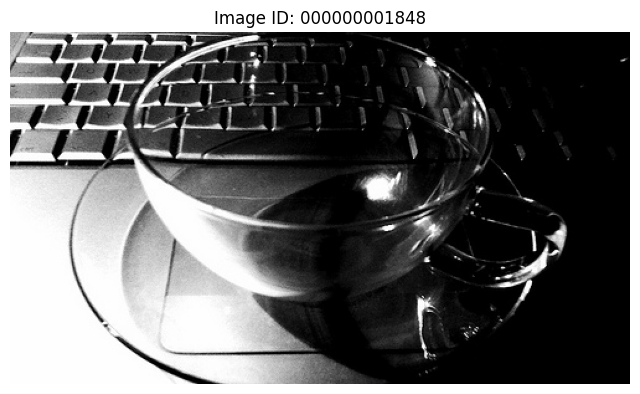

————————————————————————————————————————————————————————————
True Captions:
  • [DESCRIPTIVE]: A glass teacup with a smooth, transparent surface rests on a matching saucer, both reflecting the soft glow of ambient light. the cup's handle curves gracefully, inviting a gentle grip. behind them, a sleek laptop keyboard lies in wait, its keys poised for action. the scene is bathed in a monochromatic palette, emphasizing textures and contrasts.
  • [NARRATIVE]: A delicate glass teacup rests gracefully on a polished saucer, its translucent form catching the soft glow of ambient light. beside it, the sleek keys of a keyboard stand in quiet contrast, their metallic sheen reflecting the muted tones of the scene. the atmosphere is one of serene stillness, a moment suspended between the gentle hum of technology and the quiet elegance of a simple tea ritual.
————————————————————————————————————————————————————————————
Generated Captions:
  • [CONCISE]: A sleek black mug filled with steaming coffee

In [36]:
visualize_predictions(
    model,
    tokenizer,
    device,
    test_dataframe,
    os.path.join(path, "coco2017", "test2017"),
    test_transform,
    max_length=128,
    image_id="1848".zfill(12)
)